## Single-Index Models
### What is a single-index model?
A single-index model is where the label (y) is based solely off of one entry within the features (X).

### What's the goal?
We want to verify how well Neural Networks can learn the vector (v) that corresponds to the singular index for the feature that relates to our label y.

### Background
In modern machine learning, neural networks are very capable in learning how said vector (v) relates to some output y, however not much is known as to why they are good at this. As such, our work will attempt to answer why this is the case. For example, if were are given a dataset in d dimensions $$X \text{ in } \mathbb{R}^d$$ and there are corresponding labels, $$y_i\text{ in } \mathbb{R}$$, and we knew that the only relevant feature in order to accurately predict y is for example, $x_1^2$, it is easy to state the the vector v should only be (1, 0, 0, ... , 0). However, if we attempted to generalize this, and not know what the relevant features were, how can we understand what the vector v should be? That, in essence, is the goal of our work: to understand how the weight assignments of a neural network evolve during training, and why do neural networks estimate this vector v well.


### How is our data generated?
For this, we'll be generating our features (X) 
$$X \text{ in } \mathbb{R}^d$$
$$x_i \sim \mathcal{N}(0, I)$$
$$y_i\text{ in } \mathbb{R}$$
$$(x_i, y_i) \sim P$$
$$f(x) = \phi(v \cdot x) + \xi$$
$$\xi$$ 
is a random variable representing noise, often generated from a uniform distribution between 0 and 1.

### Experiments
1. Different number of points
2. Different number of dimensions/features

### Potential Other Experiments
3. Different phi/linq function

In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy

In [2]:
def generate_points(N=1000, d=100) -> np.array:
    """Generates N points with d dimensions 
    from a normal distribution with mean 0 and covariance 1.

    Args:
        N (int, optional): Number of points to return. Defaults to 1000.
        d (int, optional): Number of dimension for each point. Defaults to 100.

    Returns:
        np.array: The Nxd matrix of points
    """
    np.random.seed(14)

    # Generate random points from a multivariate normal distribution
    mean = np.zeros(d)
    covariance_matrix = np.identity(d)
    random_points = np.random.multivariate_normal(mean, covariance_matrix, N)
    
    return random_points

In [3]:
def phi(x):
    return np.square(x)

In [4]:
def no_change(x):
    return x

In [5]:
def get_labels(X, phi, x_i=0) -> np.array:
    """
    Generates the values for a function f(x) = phi(<v, x>) + noise
    Where noise ~ N(0, 1)
    Where v = [1, 0, 0, ...] where x_i is the index of the singular 1 in an array of 0s

    Args:
        x_i (int, optional): The index in v that is used. Defaults to 0.

    Returns:
        np.array: The array of n points
    """
    np.random.seed(14)

    v = np.zeros(shape=X.shape[1])
    v[x_i] = 1

    y = phi(X @ v)

    # add some noise
    # y = y + np.random.uniform(0, 1, size=y.shape)

    return y

In [6]:
X = generate_points(1000, 100)

In [7]:
X[0, 0]**2

2.4066530381034434

In [8]:
y = get_labels(X, phi=phi)
y[0]

2.9205963818761336

#### Wide Neural Network

In [9]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is not available.


In [10]:
def train_model(model, X, y, num_epochs=200):
    # Define our loss function and an optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to PyTorch tensors
    # move to device (cpu or cuda)
    X_tensor = torch.Tensor(X).to(device)
    y_tensor = torch.Tensor(y).view(-1, 1).to(device)
    model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    return loss.item()

In [11]:
class Nonlinearity(torch.nn.Module):
    def __init__(self, name='relu'):
        super(Nonlinearity, self).__init__()
        if name == 'relu':
            self.layer = nn.ReLU()
        elif name == 'sigmoid':
            self.layer = nn.Sigmoid()
        elif name == 'leaky_relu':
            self.layer = nn.LeakyReLU()
        elif name == 'sine':
            # There is no sine layer in PyTorch, so we apply sin function directly
            self.layer = torch.sin
        elif name == 'tanh':
            self.layer = nn.Tanh()

    def forward(self, x):
        return self.layer(x)

In [12]:
class ShallowNN(nn.Module):
    def __init__(self, dim, depth=1, width=1024, out_size=1, act_name='relu'):
        super(ShallowNN, self).__init__()
        bias=False

        self.dim = dim
        self.width = width
        self.depth = depth
        self.name = act_name

        # Wee have one hidden Relu with a linear output
        if depth == 1:
            self.first = nn.Linear(dim, width, bias=bias)
            self.fc = nn.Sequential(Nonlinearity(name=self.name),
                                    nn.Linear(width, out_size, bias=bias))
        else:
            middle_layer_template = nn.Sequential(Nonlinearity(name=self.name),
                                   nn.Linear(width, width, bias=bias))
            num_layers = depth - 1
            self.first = nn.Sequential(nn.Linear(dim, width,
                                                 bias=bias))
            self.middle = nn.ModuleList([deepcopy(middle_layer_template)
                                         for _ in range(num_layers)])

            self.last = nn.Sequential(Nonlinearity(name=self.name),
                                      nn.Linear(width, out_size,
                                                bias=bias))

    def forward(self, x):
        # Define the forward pass
        if self.depth == 1:
            return self.fc(self.first(x))
        else:
            o = self.first(x)
            for _, layer in enumerate(self.middle):
                o = layer(o)
            o = self.last(o)
            return o

In [13]:
dim = X.shape[1]
depth = 2
width = 1024
output_size = 1
wideNN = ShallowNN(dim=dim, depth=depth, width=width, 
                   out_size=output_size, act_name='relu')
train_model(wideNN, X, y, 600)

Epoch [100/600], Loss: 0.0004865039954893291
Epoch [200/600], Loss: 2.3664740638196236e-06
Epoch [300/600], Loss: 2.0398259437115485e-07
Epoch [400/600], Loss: 3.0516499549548826e-08
Epoch [500/600], Loss: 7.017662007058334e-09
Epoch [600/600], Loss: 1.911971692081238e-09


1.911971692081238e-09

In [14]:
# Get the weights from the first layer
W_1 = wideNN.first[0].weight.data

In [21]:
m = (W_1.T @ W_1)
m.cpu().numpy()

array([[ 6.7391906e+00,  7.3284382e-01, -1.2567718e-01, ...,
         1.9176367e-01,  2.6253188e-01,  4.0106347e-01],
       [ 7.3284382e-01,  4.0373497e+00,  1.1462403e-01, ...,
        -6.1894446e-03,  1.4869522e-02,  1.1133247e-01],
       [-1.2567718e-01,  1.1462403e-01,  3.8861725e+00, ...,
         5.6999918e-02, -8.4593326e-02, -2.9399544e-03],
       ...,
       [ 1.9176367e-01, -6.1894446e-03,  5.6999918e-02, ...,
         4.1918812e+00,  1.0547854e-01, -5.0576706e-03],
       [ 2.6253188e-01,  1.4869522e-02, -8.4593326e-02, ...,
         1.0547854e-01,  3.8056111e+00, -1.0213070e-01],
       [ 4.0106347e-01,  1.1133247e-01, -2.9399544e-03, ...,
        -5.0576706e-03, -1.0213070e-01,  3.8670592e+00]], dtype=float32)

In [16]:
m_scaled = (W_1.T @ W_1) * (1 / len(W_1))
m_scaled

tensor([[ 6.5812e-03,  7.1567e-04, -1.2273e-04,  ...,  1.8727e-04,
          2.5638e-04,  3.9166e-04],
        [ 7.1567e-04,  3.9427e-03,  1.1194e-04,  ..., -6.0444e-06,
          1.4521e-05,  1.0872e-04],
        [-1.2273e-04,  1.1194e-04,  3.7951e-03,  ...,  5.5664e-05,
         -8.2611e-05, -2.8710e-06],
        ...,
        [ 1.8727e-04, -6.0444e-06,  5.5664e-05,  ...,  4.0936e-03,
          1.0301e-04, -4.9391e-06],
        [ 2.5638e-04,  1.4521e-05, -8.2611e-05,  ...,  1.0301e-04,
          3.7164e-03, -9.9737e-05],
        [ 3.9166e-04,  1.0872e-04, -2.8710e-06,  ..., -4.9391e-06,
         -9.9737e-05,  3.7764e-03]])

In [23]:
import numpy as np
import matplotlib.pyplot as plt


def plot_NFM_GOP(Mat):
    # Extract the diagonal
    diagonal = np.diag(Mat)

    # Display the image
    plt.imshow(diagonal)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

TypeError: Invalid shape (100,) for image data

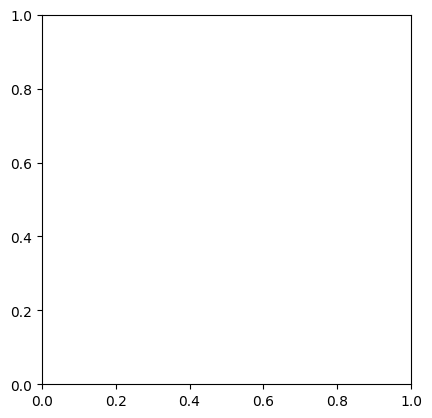

In [24]:
plot_NFM_GOP(m)

In [17]:
from numpy import linalg as LA
e_vals, e_vecs = LA.eig(m.cpu())

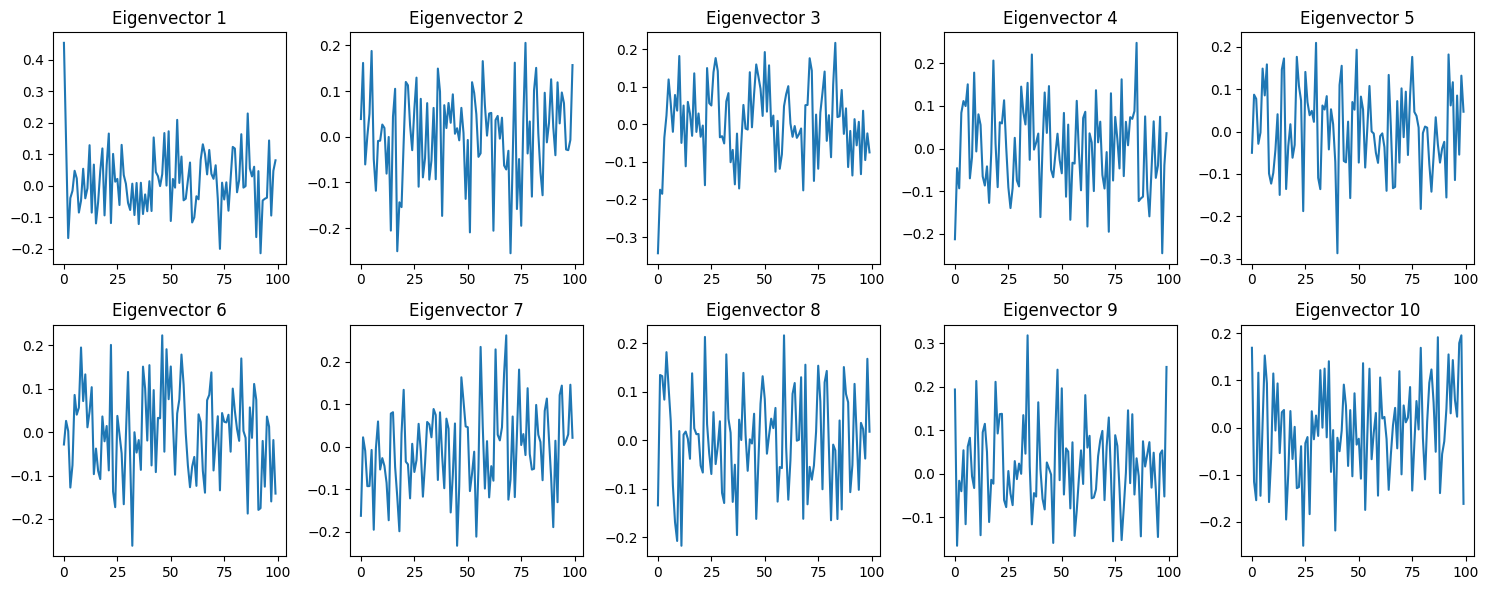

In [18]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    ax = axes[i]
    ax.plot(e_vecs[:, i])
    ax.set_title(f'Eigenvector {i+1}')

plt.tight_layout()
plt.show()

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


def get_single_index_dataset(N=1000, d=100, split_percentage=0.8):
    """
    Generates and splits the single-index model dataset into train, validation, and test sets.
    """
    # Generate data
    X = generate_points(N, d)
    y = get_labels(X, phi, x_i=0)  # Assuming the relevant feature index is 0

    # Convert to PyTorch tensors
    X_tensor = torch.Tensor(X)

    # Add an extra dimension for labels
    y_tensor = torch.Tensor(y).unsqueeze(1)

    # Split dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X_tensor, y_tensor, test_size=1 - split_percentage)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, train_size=split_percentage)

    # Determine batch size as the size of the dataset
    batch_size_train = len(X_train)
    batch_size_test = len(X_test)
    batch_size_val = len(X_val)

    # Create PyTorch datasets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    # DataLoaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size_train, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val,
                                             shuffle=False, num_workers=1)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size_test, shuffle=False)

    # Print dataset sizes
    print("Num Train: ", len(train_dataset), "Num Val: ",
          len(val_dataset), "Num Test: ", len(test_dataset))

    return train_loader, val_loader, test_loader


# Example usage
train_loader, val_loader, test_loader = get_single_index_dataset(N=1000, d=100)

Num Train:  640 Num Val:  160 Num Test:  200
